# 0. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import ttest_ind
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

# 1. Загрузка данных

In [2]:
df = pd.read_csv('data/df_summary.csv')
df

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,personal_coef,marketing_one,no_discount,marketing_two,product_group,has_anomaly
0,0,"Велосипед горный женский Stern Mira 2.0 26""",другой,13599,0,1,7,0,36,среднее,1201,0.5072,0,0,0,велосипед горный женский,1
1,0,Стол Outventure,зеленый,1499,3,0,37,0,36,среднее,1201,0.5072,0,0,0,стол outventure,0
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,3,0,37,0,36,среднее,1201,0.5072,0,0,0,набор outventure стол,0
3,3,Бутсы мужские GSD Astro,белый,1599,1,0,13,1,31,среднее,1134,0.4304,0,0,0,бутсы мужские gsd,0
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,3,0,27,1,31,среднее,1134,0.4304,0,0,0,мяч футбольный puma,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780108,178004,Пакет,коричневый,12,3,0,20,1,52,высшее,1188,0.4688,0,0,0,пакет,0
780109,178004,Кроссовки мужские FILA Regen,другой,5999,1,0,9,1,52,высшее,1188,0.4688,0,0,0,кроссовки мужские fila,0
780110,178004,Кроссовки мужские Nike Air Max Sc,другой,13999,1,0,6,1,52,высшее,1188,0.4688,0,0,0,кроссовки мужские nike,1
780111,178004,Жилет мужской IcePeak Manheim,другой,8699,1,0,9,1,52,высшее,1188,0.4688,0,0,0,жилет мужской icepeak,0


# 2. Анализ эксперимента - Первая маркетинговая кампания, проводилась в период с 5-го по 16-й день

**Вопрос заказчика:** насколько первая маркетинговая кампания была эффективна?

**Н0:** Маркетинговая кампания не эффективна

**Н1:** Маркетинговая кампания эффективна

## Тест баланса групп

In [3]:
# отберём только контрольную группу
df_control = df[df['no_discount']==1]
# убирём покупки второй маркетинговой компании
df_control = df_control[df_control['marketing_two']!=1]
c_clients = df_control.id.nunique()
print('Уникальных клиентов: ', c_clients)
print()
print('Размерность: ', df_control.shape)
print()
df_control.describe()

Уникальных клиентов:  4960

Размерность:  (54517, 17)



,id,cost,product_sex,base_sale,dt,gender,age,city,personal_coef,marketing_one,no_discount,marketing_two,has_anomaly
count,54517.000000,54517.000000,54517.000000,54517.000000,54517.000000,54517.000000,54517.000000,54517.000000,54517.000000,54517.0,54517.0,54517.0,54517.000000
mean,89382.312857,5387.227397,1.320726,0.356017,24.342921,0.550269,38.853752,1133.905828,0.459952,0.0,1.0,0.0,0.152063
std,50902.991287,10177.088265,1.175850,0.478825,15.956387,0.497471,12.233135,184.623117,0.061329,0.0,0.0,0.0,0.359085
min,23.000000,12.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.257600,0.0,1.0,0.0,0.000000
25%,44731.000000,1499.000000,0.000000,0.000000,14.000000,0.000000,31.000000,1134.000000,0.430400,0.0,1.0,0.0,0.000000
50%,90604.000000,2999.000000,1.000000,0.000000,19.000000,1.000000,38.000000,1168.000000,0.468800,0.0,1.0,0.0,0.000000
75%,133120.000000,5599.000000,3.000000,1.000000,37.000000,1.000000,47.000000,1188.000000,0.507200,0.0,1.0,0.0,0.000000
max,177967.000000,446420.000000,3.000000,1.000000,58.000000,1.000000,77.000000,1213.000000,0.558400,0.0,1.0,0.0,1.000000


In [4]:
# отберём только тестовую группу
df_test = df[df['marketing_one']==1]
# убирём покупки второй маркетинговой компании
df_test = df_test[df_test['marketing_two']!=1]
t_clients = df_test.id.nunique()
print('Уникальных клиентов: ', df_test.id.nunique())
print()
print('Размерность: ', df_test.shape)
print()
df_test.describe()

Уникальных клиентов:  4980

Размерность:  (62930, 17)



,id,cost,product_sex,base_sale,dt,gender,age,city,personal_coef,marketing_one,no_discount,marketing_two,has_anomaly
count,62930.000000,62930.000000,62930.000000,62930.000000,62930.000000,62930.000000,62930.000000,62930.000000,62930.000000,62930.0,62930.0,62930.0,62930.000000
mean,90790.374337,5231.323900,1.313857,0.352948,22.621913,0.572032,39.105880,1134.819291,0.459981,1.0,0.0,0.0,0.137009
std,51249.964193,9751.422251,1.164572,0.477890,16.582411,0.494788,12.144628,181.391825,0.058781,0.0,0.0,0.0,0.343860
min,67.000000,12.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.257600,1.0,0.0,0.0,0.000000
25%,47107.000000,1445.250000,0.000000,0.000000,9.000000,0.000000,31.000000,1134.000000,0.430400,1.0,0.0,0.0,0.000000
50%,92525.000000,2999.000000,1.000000,0.000000,17.000000,1.000000,39.000000,1167.000000,0.468800,1.0,0.0,0.0,0.000000
75%,135577.000000,5499.000000,3.000000,1.000000,36.000000,1.000000,47.000000,1188.000000,0.507200,1.0,0.0,0.0,0.000000
max,177982.000000,446420.000000,3.000000,1.000000,58.000000,1.000000,77.000000,1213.000000,0.558400,1.0,0.0,0.0,1.000000


In [5]:
df_test.shape[0] - df_control.shape[0]

8413

**Количество покупок в тестовой выборке больше на 8413 покупок чем в контрольной, что говорит о положительном влиянии маркетинговой кампании.**

**Влияние базовой скидки на обе группы почти одинаковая 35-36%.**

**Соотношение полов в каждой группе, практически одинакова, в тестовой группе мужчин - 57%, в контрольной - 55%.**

**Аномальных данных по 1.4-1.5% в обоих группах.**

In [6]:
# предположем что:
test = t_clients
control = c_clients

# общий сумарный объём трафика
total_traffic = test+control

# наблюдаемые данные в группах
observed = [test, control]

# ожидаемые данные в группах
expected = [total_traffic/2, total_traffic/2]

In [7]:
# посчитаем значение теста
chi = chisquare(observed, f_exp=expected)
print(chi)

Power_divergenceResult(statistic=0.04024144869215292, pvalue=0.8410092360823058)


In [8]:
if chi[1] < 0.01:
    print("SRM may be present - Может присутствовать несоответствие соотношения выборки")
else:
    print("SRM may not be present - Несоответствие соотношения выборки может отсутствовать")

SRM may not be present - Несоответствие соотношения выборки может отсутствовать


**Соотношение групп считается статистически одинаковым, pvalue больше 1%, несоответствие соотношения выборок может отсутствовать, баланс групп считается нормальным.**

## Среднее количество покупок, средняя выручка и средний чек на пользователя

In [9]:
# Группируем контрольную группу по пользователям
user_control = df_control.groupby('id').agg(
    purchase_count=('id', 'count'),
    total_spent=('cost', 'sum')
).reset_index()

# Группируем тестовую группу по пользователям
user_test = df_test.groupby('id').agg(
    purchase_count=('id', 'count'),
    total_spent=('cost', 'sum')
).reset_index()

# Посчитаем средние для контрольной группы
avg_purchase_count_control = user_control['purchase_count'].mean()
avg_total_spent_control = user_control['total_spent'].mean()
avg_order_value_control = df_control['cost'].mean()  # или total_spent_control / purchase_count_control
# общая выручка контрольной группы
total_revenue_control = df_control['cost'].sum()

# Посчитаем средние для тестовой группы
avg_purchase_count_test = user_test['purchase_count'].mean()
avg_total_spent_test = user_test['total_spent'].mean()
avg_order_value_test = df_test['cost'].mean()
# общая выручка тестовой группы
total_revenue_test = df_test['cost'].sum()

more_purchase = round(avg_purchase_count_test / avg_purchase_count_control * 100 - 100, 1)
more_spent = round(avg_total_spent_test / avg_total_spent_control * 100 - 100, 1)
less_order = round(avg_order_value_control / avg_order_value_test * 100 - 100, 1)

# Выведем результаты
print("Контрольная группа:")
print(f"Среднее количество покупок на пользователя: {avg_purchase_count_control}")
print(f"Средняя выручка на пользователя: {avg_total_spent_control}")
print(f"Средний чек: {avg_order_value_control}")
print(f"Общая выручка: {total_revenue_control}")

print("\nТестовая группа:")
print(f"Среднее количество покупок на пользователя: {avg_purchase_count_test}, больше контрольной на {more_purchase} %")
print(f"Средняя выручка на пользователя: {avg_total_spent_test}, больше контрольной на {more_spent} %")
print(f"Средний чек: {avg_order_value_test}, меньше контрольной на {less_order} %")
print(f"Общая выручка: {total_revenue_test}")

Контрольная группа:
Среднее количество покупок на пользователя: 10.991330645161291
Средняя выручка на пользователя: 59212.79758064516
Средний чек: 5387.227396958747
Общая выручка: 293695476

Тестовая группа:
Среднее количество покупок на пользователя: 12.636546184738956, больше контрольной на 15.0 %
Средняя выручка на пользователя: 66105.86606425703, больше контрольной на 11.6 %
Средний чек: 5231.323899570952, меньше контрольной на 3.0 %
Общая выручка: 329207213


In [15]:
print(f"Выручка в тестовой группе больше на {round((total_revenue_test - total_revenue_control)/1000000, 1)} млн.")

Выручка в тестовой группе больше на 35.6 млн.


**Среднее количество покупок на пользователя в тестовой группе больше на 15%**

**Средняя выручка на пользователя в тестовой группе больше на 11.6%**

**Общая выручка в тестовой группе увеличилась на 35,6 млн. рублей, что говорит о положительной маркетинговой кампании.**

**Средний чек на пользователя в тестовой группу меньше на 3%**

**Количество покупок и выручка выросли, маркетинговая кампания простимулировала клиентов положительно на покупки.**

**На средний чек повлияло негативно, возможно, кампания стимулировала более частые, но менее дорогие покупки или привлекла сегмент пользователей, склонных к более частым покупкам с меньшим средним чеком**

## Анализ групп перед статистическим тестом эффективности

### Анализ зависимости групп

In [57]:
pd.merge(df_control, df_test, how='inner', on=['id'])

,id,product_x,colour_x,cost_x,product_sex_x,base_sale_x,dt_x,gender_x,age_x,education_x,...,gender_y,age_y,education_y,city_y,personal_coef_y,marketing_one_y,no_discount_y,marketing_two_y,product_group_y,has_anomaly_y


**При объединение таблиц по id, совподающих нету, поэтому группы считаются независимы.**

Зависимые vs Независимые группы
Независимые группы (чаще всего в А/B тестах)
Как понять: Это когда разные люди попадают в разные группы случайным образом.

Примеры:

1000 пользователей случайно делятся на 2 группы по 500

Группа A видит старый дизайн, группа B — новый

Каждый пользователь находится только в одной группе

Признаки:

Участники в группе A и группе B — это разные люди

Нет никакой связи между конкретным человеком в группе A и конкретным человеком в группе B

Зависимые группы (парные выборки)
Как понять: Когда мы измеряем одних и тех же людей/объектов в разных условиях.

Примеры:

Измерили давление у людей до лекарства и после

Один и тот же пользователь оценивает старую и новую версию сайта

Сравнение продаж в одних и тех же магазинах до и после акции

Признаки:

Те же самые участники в обеих группах

Есть прямая связь между измерениями

Как проверить на практике:
1. Спросите себя:
"Это одни и те же люди?" → Если ДА → зависимые группы

"Это разные люди?" → Если ДА → независимые группы

2. Посмотрите на дизайн эксперимента:
Случайное разделение на группы → независимые

Измерения "до/после" → зависимые

### Анализ количества покупок на одного пользователя

#### Распределение

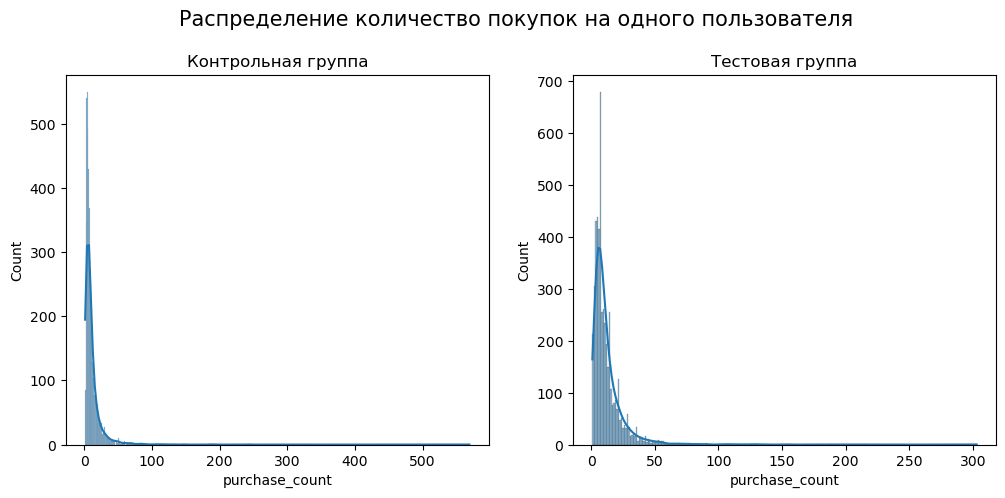

In [58]:
plt.figure(figsize=(12, 5))
plt.suptitle('Распределение количество покупок на одного пользователя', fontsize=15)
plt.subplots_adjust(top=0.85)

plt.subplot(1, 2, 1)
sns.histplot(user_control['purchase_count'], kde=True)
plt.title("Контрольная группа")

plt.subplot(1, 2, 2)
sns.histplot(user_test['purchase_count'], kde=True)
plt.title("Тестовая группа")
plt.show()

**Тест Шапиро - Уилка** - Для проверки нормального распределения

порог значимости 5%

In [59]:
stats.shapiro(user_control['purchase_count']) 
# используем тест Шапиро - Уилка для контрольной группы

ShapiroResult(statistic=0.3887054499744955, pvalue=2.3535339313495854e-84)

In [60]:
stats.shapiro(user_test['purchase_count']) 
# используем тест Шапиро - Уилка для тестовой группы

ShapiroResult(statistic=0.519335458038387, pvalue=3.3395545830157135e-79)

**Визуализация и Тест Шапиро - Уилка показали что не подходят под нормальное распределение pvalue меньше 5%.**

#### Вывод

**Группы независимы и не имеют нормального распределения - поэтому выбирается статистический Тест Манна-Уитни.**

### Анализ выручки на одного пользователя

#### Распределение

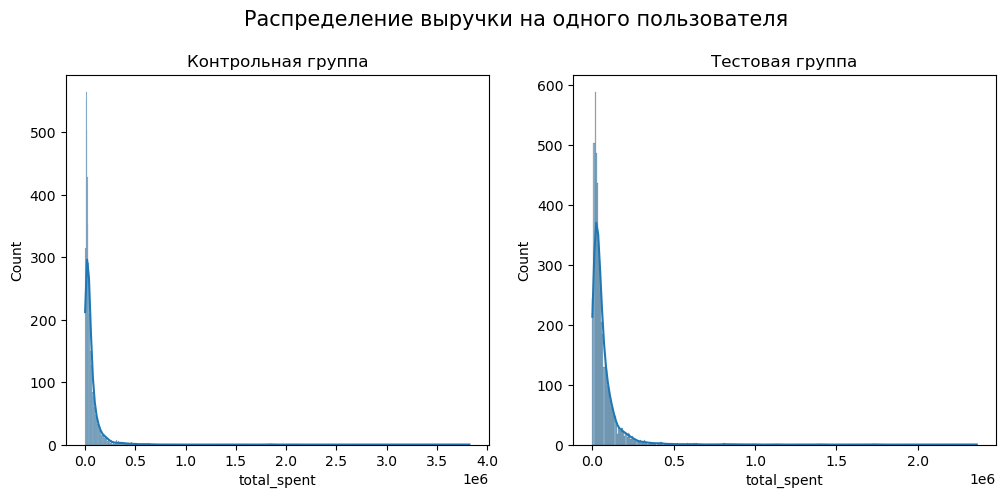

In [61]:
plt.figure(figsize=(12, 5))
plt.suptitle('Распределение выручки на одного пользователя', fontsize=15)
plt.subplots_adjust(top=0.85)

plt.subplot(1, 2, 1)
sns.histplot(user_control['total_spent'], kde=True)
plt.title("Контрольная группа")

plt.subplot(1, 2, 2)
sns.histplot(user_test['total_spent'], kde=True)
plt.title("Тестовая группа")
plt.show()

In [62]:
# используем тест Шапиро - Уилка для тестовой группы
print('Контрольная группа: ', stats.shapiro(user_control['purchase_count']))
print('Тестовая группа: ', stats.shapiro(user_test['purchase_count']))

Контрольная группа:  ShapiroResult(statistic=0.3887054499744955, pvalue=2.3535339313495854e-84)
Тестовая группа:  ShapiroResult(statistic=0.519335458038387, pvalue=3.3395545830157135e-79)


**Визуализация и Тест Шапиро - Уилка показали что не подходят под нормальное распределение.**

#### Вывод

**Группы независимы и не имеют нормального распределения - поэтому выбирается статистический Тест Манна-Уитни.**

### Анализ среднего чека на одного пользователя

#### Распределение

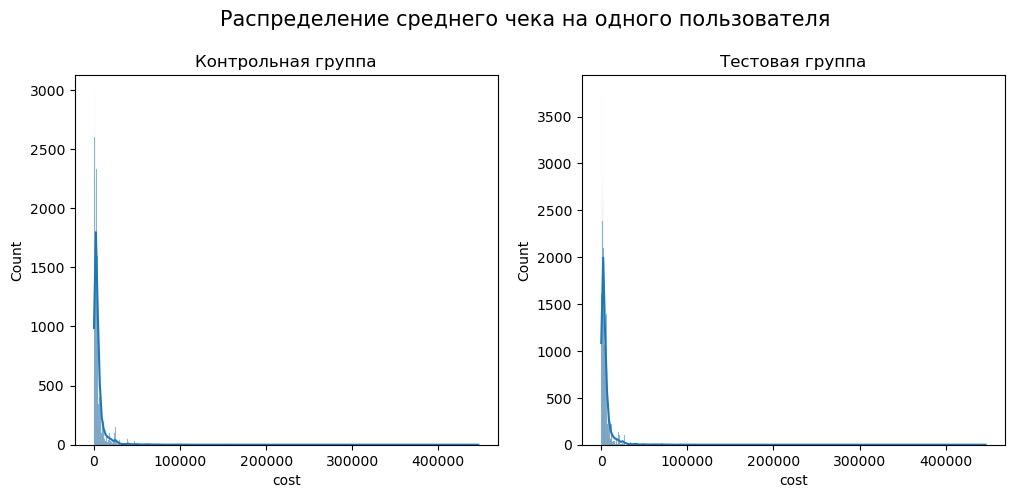

In [63]:
plt.figure(figsize=(12, 5))
plt.suptitle('Распределение среднего чека на одного пользователя', fontsize=15)
plt.subplots_adjust(top=0.85)

plt.subplot(1, 2, 1)
sns.histplot(df_control['cost'], kde=True)
plt.title("Контрольная группа")

plt.subplot(1, 2, 2)
sns.histplot(df_test['cost'], kde=True)
plt.title("Тестовая группа")
plt.show()

In [65]:
# используем тест Шапиро - Уилка для тестовой группы
print('Контрольная группа: ', stats.shapiro(df_control['cost']))
print('Тестовая группа: ', stats.shapiro(df_test['cost']))

Контрольная группа:  ShapiroResult(statistic=0.3821521018223385, pvalue=8.102535177527361e-151)
Тестовая группа:  ShapiroResult(statistic=0.3833194341112892, pvalue=7.594505425523485e-155)


**Визуализация и Тест Шапиро - Уилка показали что не подходят под нормальное распределение.**

#### Вывод

**Группы независимы и не имеют нормального распределения - поэтому выбирается статистический Тест Манна-Уитни.**

### Вывод

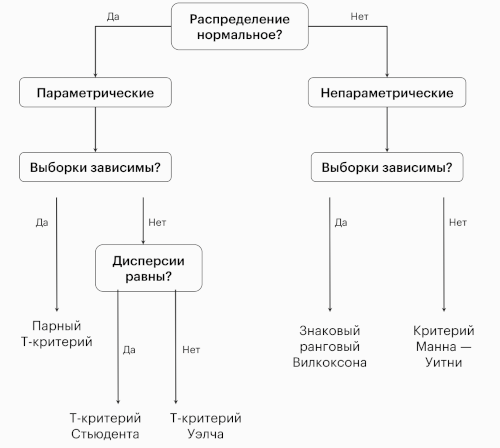

**Для всех метрик применяю стистический тест Манна-Уитни**

## Стистический тест Манна-Уитни для проверки

In [66]:
# Для количества покупок на пользователя
stat, p = mannwhitneyu(user_control['purchase_count'], user_test['purchase_count'])
print(f"Манн-Уитни для количества покупок: stat={stat}, p={p}")
print()
print()
# Для выручки на пользователя
stat2, p2 = mannwhitneyu(user_control['total_spent'], user_test['total_spent'])
print(f"Манн-Уитни для выручки на пользователя: stat={stat2}, p={p2}")
print()
print()
# Для среднего чека (на уровне покупок)
stat3, p3 = mannwhitneyu(df_control['cost'], df_test['cost'])
print(f"Манн-Уитни для среднего чека: stat={stat3}, p={p3}")
print()

Манн-Уитни для количества покупок: stat=10258933.0, p=1.3286090165251081e-48


Манн-Уитни для выручки на пользователя: stat=10824492.0, p=1.4501033733582358e-26


Манн-Уитни для среднего чека: stat=1728643610.5, p=0.022044081675299927



**Существует статистически значимая разница в количестве покупок между группами, маркетинговая кампания значимо повлияла на частоту покупок**

**Существует статистически значимая разница в выручке на пользователя между группами, маркетинговая кампания значимо повлияла на общую выручку**

**Разница в среднем чеке статистически значима, но менее выражена.**

## Вывод

**Отвергается нулевая гипотеза и применяется альтернативная гипотеза.**

**Н1:** Маркетинговая кампания эффективна
****

Кампания успешна - она привела к значимому увеличению ключевых метрик

Фокус на частоту покупок - кампания особенно эффективна для увеличения количества транзакций, увеличение составило на 15%

Эффективность так же отразилась на выручке, увеличение составило на 11.6%

Средний чек снизился значимо, возможно, пользователи стали покупать более дешевые товары или маркетинговая кампания проводилась с ниже средним чеком

****
Рекомендации:

Продолжить/масштабировать данную маркетинговую стратегию

Проанализировать причины снижения среднего чека:

Возможно, предложить дополнительные стимулы для увеличения суммы покупок

Или сфокусироваться на перекрестных продажах

Изучить, какие именно аспекты кампании вызвали увеличение частоты покупок

# 3. Вторая маркетинговая кампания, проводилась на жителях города 1134 и скидка всем каждое 15-е число месяца (15-й и 45-й день в нашем случае)

**Вопрос заказчика:** насколько вторая маркетинговая кампания была эффективна?

**Н0:** Маркетинговая кампания не эффективна

**Н1:** Маркетинговая кампания эффективна

In [13]:
# Выбрал только вторую маркетинговую компанию
df_two = df[(df['marketing_two'] == 1) & (df['marketing_one'] != 1)]
print('Размер: ', df_two.shape)

Размер:  (9896, 17)


In [14]:
# Описательная статистика для всех типов данных
df_two.describe(include='all')

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,personal_coef,marketing_one,no_discount,marketing_two,product_group,has_anomaly
count,9896.000000,9896,9896,9896.000000,9896.000000,9896.000000,9896.000000,9896.000000,9896.000000,9896,9896.0,9896.000000,9896.0,9896.000000,9896.0,9896,9896.000000
unique,NaN,4538,50,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,2204,NaN
top,NaN,Брюки мужские Demix,другой,NaN,NaN,NaN,NaN,NaN,NaN,среднее,NaN,NaN,NaN,NaN,NaN,кроссовки мужские nike,NaN
freq,NaN,55,3540,NaN,NaN,NaN,NaN,NaN,NaN,8266,NaN,NaN,NaN,NaN,NaN,130,NaN
mean,88927.046281,NaN,NaN,5854.654507,1.323666,0.346403,25.367825,0.555477,39.301435,NaN,1134.0,0.461119,0.0,0.091451,1.0,NaN,0.162490
std,51988.062906,NaN,NaN,10854.249116,1.175817,0.475847,14.267569,0.496938,12.259160,NaN,0.0,0.058803,0.0,0.288264,0.0,NaN,0.368918
min,98.000000,NaN,NaN,25.000000,0.000000,0.000000,15.000000,0.000000,6.000000,NaN,1134.0,0.257600,0.0,0.000000,1.0,NaN,0.000000
25%,44515.000000,NaN,NaN,1539.000000,0.000000,0.000000,15.000000,0.000000,32.000000,NaN,1134.0,0.430400,0.0,0.000000,1.0,NaN,0.000000
50%,88556.000000,NaN,NaN,3199.000000,1.000000,0.000000,15.000000,1.000000,39.000000,NaN,1134.0,0.468800,0.0,0.000000,1.0,NaN,0.000000
75%,133881.750000,NaN,NaN,5999.000000,3.000000,1.000000,45.000000,1.000000,47.000000,NaN,1134.0,0.507200,0.0,0.000000,1.0,NaN,0.000000


In [15]:
df_two.id.nunique()

5288

In [24]:
def format_number(num):
    if num >= 1000000000:
        return f"{round(num / 1000000000, 1)} млдр"
    elif num >= 1000000:
        return f"{round(num / 1000000,1)} млн"
    else:
        return str(num)

In [25]:
# Для маркетинговой кампании (группа 1):
df_two_total_revenue = df_two.cost.sum() # выручка только второй маркетинговой компании
df_two_purchases = df_two.shape[0] # количество покупок только второй маркетинговой компании


# Все клиенты до кампании (группа 2)
df_total_revenue = df[(df['marketing_two'] != 1) & (df['marketing_one'] != 1)].cost.sum() # общая выручка всех данных
df_count_purchases = df[(df['marketing_two'] != 1) & (df['marketing_one'] != 1)].shape[0]  # количество покупок всех данных


# увиличение покупок в процентах
df_purchases_percent = round(df_two_purchases/df_count_purchases*100, 2)
# увеличение выручки в процентах
df_revenue_percent = round(df_two_total_revenue/df_total_revenue*100, 2)

print(f'Количество покупок до кампании {df_count_purchases} и выручка {format_number(df_total_revenue)}')
print()
print(f'Вторая маркетинговая кампания принесла {df_two_purchases} покупки, покупки увеличились на {df_purchases_percent} процента.')
print()
print(f'Вторая маркетинговая кампания принесла {format_number(df_two_total_revenue)} выручки, выручка увеличилась на {df_revenue_percent} процента.')

Количество покупок до кампании 706319 и выручка 3.8 млдр

Вторая маркетинговая кампания принесла 9896 покупки, покупки увеличились на 1.4 процента.

Вторая маркетинговая кампания принесла 57.9 млн выручки, выручка увеличилась на 1.51 процента.


****
**ВЫВОД:**

**Отвергается нулевая гипотеза и применяется альтернативная гипотеза.**

**Н1:** Маркетинговая кампания эффективна

**Вторая маркетинговая компания была эффективна, на 1.5% увеличилась выручка и на 1.4% увеличились покупки.**